In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [6]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    ################################################ a = act(s)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ################################################ s', r = env(s, a)
    ################################################ s', Q = env(s, a)
    ################################################ ~s', ~Q = env(s, ~a)
    e_next_states_logits, eQs = Env(actions=actions_labels, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size)
    a_next_states_logits, aQs = Env(actions=actions_logits, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size, reuse=True)
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, 
                                                                   labels=next_states_labels))
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                    labels=next_states_labels))
    eQs_logits = tf.reshape(eQs, shape=[-1])
    aQs_logits = tf.reshape(aQs, shape=[-1])
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=eQs_logits, # GAN
                                                                    labels=rates)) # 0-1 real
    #################################################### s'', Q' = ~env(s', ~a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    _, aQs2 = Env(actions=next_actions_logits, states=next_states, hidden_size=hidden_size, 
                  action_size=action_size, state_size=state_size, reuse=True)
    aQs2_logits = tf.reshape(aQs2, shape=[-1]) * (1-dones)
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                    labels=tf.zeros_like(rates))) # min
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                     labels=tf.ones_like(rates))) # max
#     ###################################################### Q(s,a)= r + Q'(s',a') # max
#     ###################################################### ~Q(s,~a)= r # min
#     ###################################################### ~Q(s,~a)= r + Q'(s',a') # max
#     targetQs = rewards + (gamma * aQs2_logits)
#     eloss += tf.reduce_mean(tf.square(eQs_logits - targetQs)) # real
#     eloss += tf.reduce_mean((aQs_logits+aQs2_logits)/2) # min
#     aloss2 += -tf.reduce_mean((aQs_logits+aQs2_logits)/2) # max
    return actions_logits, aloss, eloss, aloss2

In [7]:
def model_opt(a_loss, e_loss, a_loss2, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, e_opt, a_opt2

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        e_loss=self.e_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        e_learning_rate=e_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
#         return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, gamma=gamma,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list, aloss2_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        aloss_batch, eloss_batch, aloss2_batch = [], [], []
        total_reward = 0
        state = env.reset()
        num_step = 0
        rate = -1

        # Training steps/batches
        while True:
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Training with the maxrated minibatch
            batch = memory.buffer
            #for idx in range(memory_size// batch_size):
            while True:
                idx = np.random.choice(np.arange(memory_size// batch_size))
                states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                states = states[rates >= np.max(rates)]
                actions = actions[rates >= np.max(rates)]
                next_states = next_states[rates >= np.max(rates)]
                rewards = rewards[rates >= np.max(rates)]
                dones = dones[rates >= np.max(rates)]
                rates = rates[rates >= np.max(rates)]
                if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
                    break
            aloss, _ = sess.run([model.a_loss, model.a_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            eloss, _ = sess.run([model.e_loss, model.e_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            aloss2, _= sess.run([model.a_loss2, model.a_opt2], 
                                 feed_dict = {model.states: states, 
                                              model.actions: actions,
                                              model.next_states: next_states,
                                              model.rewards: rewards,
                                              model.dones: dones,
                                              model.rates: rates})
            # print(len(dones), np.count_nonzero(dones), np.max(rates))
            aloss_batch.append(aloss)
            eloss_batch.append(eloss)
            aloss2_batch.append(aloss2)
            if done is True:
                break
                
        # Rating the latest played episode
        rate = total_reward/500 # update rate at the end/ when episode is done
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                memory.buffer[-1-idx][-1] = rate # rate the trajectory/data

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        aloss2_list.append([ep, np.mean(aloss2_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:16.0000 R:16.0000 rate:0.0320 aloss:0.7454 eloss:2.0542 aloss2:1.3793 exploreP:0.9984
Episode:1 meanR:21.5000 R:27.0000 rate:0.0540 aloss:0.7479 eloss:2.0564 aloss2:1.3830 exploreP:0.9958
Episode:2 meanR:28.6667 R:43.0000 rate:0.0860 aloss:0.7448 eloss:2.1187 aloss2:1.3505 exploreP:0.9915
Episode:3 meanR:28.7500 R:29.0000 rate:0.0580 aloss:0.7336 eloss:2.0202 aloss2:1.4000 exploreP:0.9887
Episode:4 meanR:29.4000 R:32.0000 rate:0.0640 aloss:0.7488 eloss:2.0615 aloss2:1.3720 exploreP:0.9856
Episode:5 meanR:27.6667 R:19.0000 rate:0.0380 aloss:0.7457 eloss:2.0163 aloss2:1.3932 exploreP:0.9837
Episode:6 meanR:25.8571 R:15.0000 rate:0.0300 aloss:0.7441 eloss:2.0089 aloss2:1.4043 exploreP:0.9822
Episode:7 meanR:31.3750 R:70.0000 rate:0.1400 aloss:0.7375 eloss:2.0376 aloss2:1.3800 exploreP:0.9755
Episode:8 meanR:29.7778 R:17.0000 rate:0.0340 aloss:0.7494 eloss:2.0017 aloss2:1.3980 exploreP:0.9738
Episode:9 meanR:27.8000 R:10.0000 rate:0.0200 aloss:0.7437 eloss:2.0795 aloss2:1.3

Episode:80 meanR:26.6049 R:20.0000 rate:0.0400 aloss:0.7478 eloss:1.5909 aloss2:1.8311 exploreP:0.8081
Episode:81 meanR:26.8537 R:47.0000 rate:0.0940 aloss:0.7572 eloss:1.5816 aloss2:1.8306 exploreP:0.8043
Episode:82 meanR:26.7590 R:19.0000 rate:0.0380 aloss:0.7122 eloss:1.5990 aloss2:1.8299 exploreP:0.8028
Episode:83 meanR:26.8571 R:35.0000 rate:0.0700 aloss:0.7334 eloss:1.5656 aloss2:1.8862 exploreP:0.8001
Episode:84 meanR:26.6824 R:12.0000 rate:0.0240 aloss:0.7031 eloss:1.6052 aloss2:1.8680 exploreP:0.7991
Episode:85 meanR:26.5233 R:13.0000 rate:0.0260 aloss:0.7330 eloss:1.5513 aloss2:1.9159 exploreP:0.7981
Episode:86 meanR:26.3678 R:13.0000 rate:0.0260 aloss:0.7349 eloss:1.5536 aloss2:1.9024 exploreP:0.7971
Episode:87 meanR:26.5227 R:40.0000 rate:0.0800 aloss:0.7247 eloss:1.5780 aloss2:1.8889 exploreP:0.7939
Episode:88 meanR:26.4045 R:16.0000 rate:0.0320 aloss:0.7253 eloss:1.5829 aloss2:1.9022 exploreP:0.7927
Episode:89 meanR:26.2556 R:13.0000 rate:0.0260 aloss:0.7516 eloss:1.5427 

Episode:159 meanR:20.9200 R:11.0000 rate:0.0220 aloss:0.7812 eloss:1.3757 aloss2:2.4866 exploreP:0.6932
Episode:160 meanR:20.9100 R:24.0000 rate:0.0480 aloss:0.7579 eloss:1.3848 aloss2:2.5011 exploreP:0.6916
Episode:161 meanR:21.0000 R:39.0000 rate:0.0780 aloss:0.7926 eloss:1.4212 aloss2:2.4734 exploreP:0.6889
Episode:162 meanR:20.9800 R:16.0000 rate:0.0320 aloss:0.7966 eloss:1.4092 aloss2:2.4524 exploreP:0.6878
Episode:163 meanR:20.6300 R:10.0000 rate:0.0200 aloss:0.7636 eloss:1.4059 aloss2:2.6031 exploreP:0.6872
Episode:164 meanR:20.5000 R:14.0000 rate:0.0280 aloss:0.7723 eloss:1.3660 aloss2:2.7049 exploreP:0.6862
Episode:165 meanR:20.3400 R:12.0000 rate:0.0240 aloss:0.7394 eloss:1.3847 aloss2:2.4580 exploreP:0.6854
Episode:166 meanR:20.3400 R:15.0000 rate:0.0300 aloss:0.7488 eloss:1.3737 aloss2:2.4612 exploreP:0.6844
Episode:167 meanR:20.3600 R:23.0000 rate:0.0460 aloss:0.7841 eloss:1.3756 aloss2:2.5883 exploreP:0.6828
Episode:168 meanR:19.8400 R:16.0000 rate:0.0320 aloss:0.7591 elo

Episode:238 meanR:22.6500 R:26.0000 rate:0.0520 aloss:0.6885 eloss:1.3227 aloss2:2.7662 exploreP:0.5740
Episode:239 meanR:22.9900 R:56.0000 rate:0.1120 aloss:0.6861 eloss:1.3322 aloss2:2.8040 exploreP:0.5708
Episode:240 meanR:23.3700 R:49.0000 rate:0.0980 aloss:0.6814 eloss:1.3240 aloss2:2.8540 exploreP:0.5681
Episode:241 meanR:24.1200 R:122.0000 rate:0.2440 aloss:0.6804 eloss:1.3157 aloss2:2.8038 exploreP:0.5613
Episode:242 meanR:25.2800 R:143.0000 rate:0.2860 aloss:0.6762 eloss:1.3047 aloss2:2.8619 exploreP:0.5535
Episode:243 meanR:26.0300 R:87.0000 rate:0.1740 aloss:0.6734 eloss:1.3146 aloss2:2.8938 exploreP:0.5488
Episode:244 meanR:26.5800 R:67.0000 rate:0.1340 aloss:0.6769 eloss:1.3253 aloss2:2.8829 exploreP:0.5452
Episode:245 meanR:27.0400 R:58.0000 rate:0.1160 aloss:0.6740 eloss:1.3095 aloss2:2.9507 exploreP:0.5421
Episode:246 meanR:28.2100 R:127.0000 rate:0.2540 aloss:0.6788 eloss:1.3050 aloss2:2.9544 exploreP:0.5354
Episode:247 meanR:30.1100 R:201.0000 rate:0.4020 aloss:0.6739

Episode:317 meanR:122.0600 R:230.0000 rate:0.4600 aloss:0.7025 eloss:1.2975 aloss2:2.9818 exploreP:0.1909
Episode:318 meanR:124.4600 R:259.0000 rate:0.5180 aloss:0.7035 eloss:1.3513 aloss2:2.9675 exploreP:0.1863
Episode:319 meanR:127.2400 R:318.0000 rate:0.6360 aloss:0.7082 eloss:1.2859 aloss2:2.9661 exploreP:0.1807
Episode:320 meanR:131.7100 R:479.0000 rate:0.9580 aloss:0.7178 eloss:1.3022 aloss2:2.9829 exploreP:0.1727
Episode:321 meanR:134.8000 R:340.0000 rate:0.6800 aloss:0.7173 eloss:1.3117 aloss2:2.9883 exploreP:0.1673
Episode:322 meanR:138.8800 R:463.0000 rate:0.9260 aloss:0.7208 eloss:1.2965 aloss2:2.9748 exploreP:0.1602
Episode:323 meanR:141.8500 R:309.0000 rate:0.6180 aloss:0.7208 eloss:1.3395 aloss2:2.9879 exploreP:0.1556
Episode:324 meanR:146.2800 R:491.0000 rate:0.9820 aloss:0.7229 eloss:1.3272 aloss2:2.9546 exploreP:0.1486
Episode:325 meanR:149.9400 R:428.0000 rate:0.8560 aloss:0.7150 eloss:1.3341 aloss2:2.9451 exploreP:0.1428
Episode:326 meanR:154.6700 R:500.0000 rate:1.0

Episode:395 meanR:402.3200 R:500.0000 rate:1.0000 aloss:0.6243 eloss:1.7769 aloss2:2.1448 exploreP:0.0145
Episode:396 meanR:406.2200 R:500.0000 rate:1.0000 aloss:0.6066 eloss:1.8073 aloss2:2.1244 exploreP:0.0143
Episode:397 meanR:410.2100 R:500.0000 rate:1.0000 aloss:0.6053 eloss:1.8245 aloss2:2.1023 exploreP:0.0141
Episode:398 meanR:413.5000 R:500.0000 rate:1.0000 aloss:0.6098 eloss:1.7902 aloss2:2.1178 exploreP:0.0139
Episode:399 meanR:416.6600 R:500.0000 rate:1.0000 aloss:0.6151 eloss:1.8031 aloss2:2.1306 exploreP:0.0137
Episode:400 meanR:420.0500 R:500.0000 rate:1.0000 aloss:0.6011 eloss:1.8162 aloss2:2.1104 exploreP:0.0135
Episode:401 meanR:423.8800 R:500.0000 rate:1.0000 aloss:0.6097 eloss:1.8205 aloss2:2.1030 exploreP:0.0133
Episode:402 meanR:427.8100 R:500.0000 rate:1.0000 aloss:0.5870 eloss:1.8650 aloss2:2.0710 exploreP:0.0132
Episode:403 meanR:431.1000 R:500.0000 rate:1.0000 aloss:0.6014 eloss:1.8374 aloss2:2.0647 exploreP:0.0130
Episode:404 meanR:434.4200 R:500.0000 rate:1.0

Episode:473 meanR:499.9800 R:500.0000 rate:1.0000 aloss:0.4577 eloss:2.0512 aloss2:1.5848 exploreP:0.0101
Episode:474 meanR:499.9800 R:500.0000 rate:1.0000 aloss:0.4542 eloss:2.0524 aloss2:1.5847 exploreP:0.0101
Episode:475 meanR:499.9800 R:500.0000 rate:1.0000 aloss:0.4626 eloss:2.0471 aloss2:1.5845 exploreP:0.0101
Episode:476 meanR:499.9800 R:500.0000 rate:1.0000 aloss:0.4593 eloss:2.0471 aloss2:1.5828 exploreP:0.0101
Episode:477 meanR:499.9800 R:500.0000 rate:1.0000 aloss:0.4551 eloss:2.0568 aloss2:1.5738 exploreP:0.0101
Episode:478 meanR:500.0000 R:500.0000 rate:1.0000 aloss:0.4416 eloss:2.0597 aloss2:1.5628 exploreP:0.0101


# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

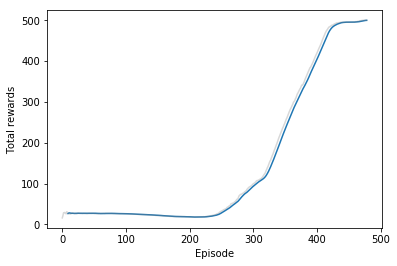

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

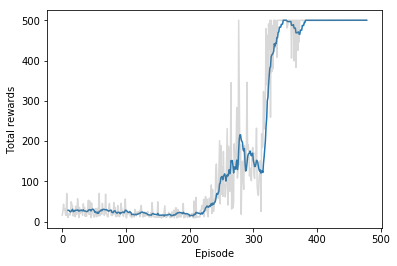

In [17]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

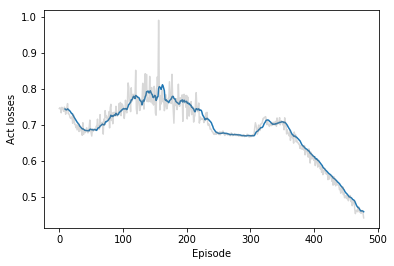

In [18]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

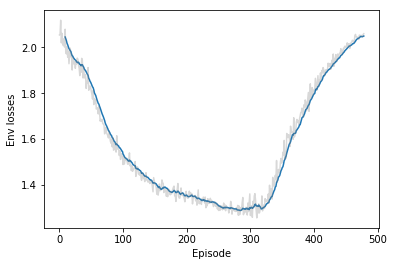

In [19]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Act losses 2')

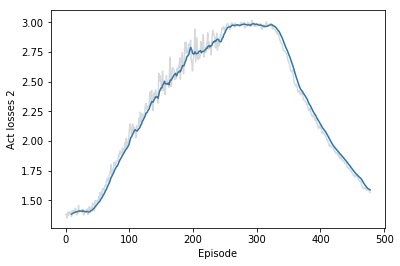

In [20]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

## Testing

Let's checkout how our trained agent plays the game.

In [21]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
